# Assessing models of innovation in fiction

To confirm that the patterns we're seeing in academic journal articles aren't unique to that corpus, we also built and modeled a fiction dataset.

This dataset is imperfect for several reasons — mainly that copyright law makes it difficult to construct a large, full-text dataset of twentieth-century fiction. We do have full text of many works, but to create an even distribution for the topic model it was necessary to supplement our full-text corpus with some books that are present only as word counts.

**Let's do imports and examine the metadata.**

In [2]:
# necessary imports

import pandas as pd
from scipy.stats import pearsonr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
# Create the dataframe we'll analyze

meta = pd.read_csv('../fiction/enriched_metadata.tsv', sep = '\t')
meta = meta.loc[~pd.isnull(meta.paperId), : ]
meta.rename(columns={'paperId': 'docid'}, inplace=True)
meta['docid'] = meta['docid'].astype(str)
meta.set_index('docid', inplace = True)

# To analyze correlations with age, we use a smaller subset
# of the corpus where we can confirm the author's birthdate
agemeta = meta.loc[~pd.isnull(meta.author_age)]
print(f'The whole corpus shape is{meta.shape} but the age subset only {agemeta.shape}.')
# meta = meta.loc[meta.doctype == 'article | research-article', : ]

# We also create a list of the docids that have been discussed
# in critical articles, and a contrast set that have the 
# same distribution over time but are not mentioned in our
# literary studies corpus.

discussed = meta.loc[meta.is_discussed == True].index.tolist()
discussed_contrast = meta.loc[meta.discussed_contrast == True].index.tolist()

print('We have ', len(discussed), ' discussed docs and ', len(discussed_contrast), ' contrast docs.')

The whole corpus shape is(8918, 28) but the age subset only (4434, 28).
We have  463  discussed docs and  926  contrast docs.


### Inspect the corpus

Let's see how many books we have as full text.

In [4]:
print(meta['SOURCE'].unique())

# We have full text for books drawn from sources k, g, and hathi_fulltext.
# We have word counts only for 'extracted_features'.

# First group meta by decade and source, then
# build a stacked bar chart to display the distribution of sources
# over time.

meta['decade'] = (meta.PUBL_DATE // 10) * 10
meta['decade'] = meta['decade'].astype(str)
meta['decade'] = meta['decade'].str.replace('nan', 'unknown')

source_decade = meta.groupby(['decade', 'SOURCE']).size().unstack().fillna(0)
source_decade.head()


['k' 'extracted_features' 'hathi_fulltext' 'g']


SOURCE,extracted_features,g,hathi_fulltext,k
decade,,,,
1890,85.0,188.0,585.0,2.0
1900,41.0,347.0,447.0,25.0
1910,19.0,394.0,418.0,29.0
1920,282.0,151.0,106.0,321.0
1930,204.0,2.0,0.0,642.0


<Axes: xlabel='decade'>

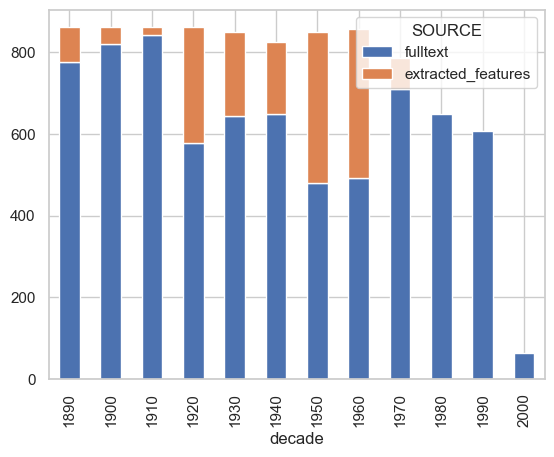

In [5]:
source_decade['fulltext'] = source_decade['g'] + source_decade['k'] + source_decade['hathi_fulltext']
sns.set(style="whitegrid")
source_decade[['fulltext', 'extracted_features']].plot(kind='bar', stacked=True)

**Interpretation**

This distribution is flatter than it looks, because it's counting numbers of books and we actually selected books up to a cap defined in terms of total-numbers-of-words. The later books are longer. However, there is a spot in the middle of the distribution where we don't have as much full-text |and this could somehow handicap our embedding model.

Nevertheless, as we'll see, the embedding model is able to perform well on some tasks.

### How we trained the embedding model

We used multiple negatives ranking loss, as with the lit studies model -- and as in that case, we included some paraphrased passages (though only about 10%). One thing we did that seems to have been important: we randomized personal (character) names in one passage of each pair — keeping a distinction between first and last, gender signals, etc, but just choosing different names. This made the matching task much more difficult and may have forced the model to learn more. Otherwise it can just match passages about Robert.

One could also try that method with nonfiction, but it would be debatable: proper names are not arbitrary in nonfiction. They convey content.

*Note*: There is at present a small glitch in our embedding dataset. Some books are absent, and I think it's not just the books we would expect (the ones in orange above.) I don't think it's enough to radically change results, but I'll need to fix this and understand the source of the glitch. It presumably happened when I applied the model to the fiction dataset.

### Modeling author age

We have author birthdates for a subset of authors in the data for [the cohort succession article](https://sociologicalscience.com/articles-v9-8-184/) (Underwood et al 2022). We matched these with the authors and titles in our corpus to confirm birth year for authors of about 4000 books. Age is then publication date minus birth year.

How is it related to precocity?

In [18]:
def controlled_model(reg_df):

	# Define the independent variables including the interaction term
	columns = ['novelty', 'precocity', 'precocity^2']
	for yr in range(1910, 1980, 5):
		columns.append('year' + str(yr))
	
	X = []
	for idx, row in reg_df.iterrows():
		newrow = dict()
		newrow['precocity'] = row['precocity']
		newrow['novelty'] = row['novelty']
		newrow['precocity^2'] = row['precocity'] ** 2
		newrow['ages'] = row['ages']
		for yr in range(1910, 1980, 5):
			col = 'year' + str(yr)
			if (row['date'] >= yr) and (row['date'] <= yr + 5):
				newrow[col] = 1
			else:
				newrow[col] = 0
			X.append(newrow)

	X = pd.DataFrame(X)

	# Add a constant to the model (the intercept)
	X = sm.add_constant(X)

	# Define the dependent variable
	y = X['ages']

	X = X.drop('ages', axis=1)

	# Fit the linear regression model
	model = sm.OLS(y, X).fit()

	# Print the summary of the model
	print(model.summary())

In [28]:
def run_topic_model(path_to_model, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    date = []
    ages = []

    for decade in range(1910, 1980, 5):
        
        data = pd.read_csv(path_to_model + str(decade) + 's_docs.tsv', sep = '\t')

        data.set_index('docid', inplace=True)

        data = data.join(agemeta['author_age'], how='inner')

        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        r, p = pearsonr(selected.author_age, selected.precocity)
        print(decade, round(r, 5))

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        date.extend(selected.date.values.tolist())
        ages.extend(selected.author_age.values.tolist())

    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'date': date, 'ages': ages})
    controlled_model(reg_df)
    return reg_df

reg_df = run_topic_model('../topicmodel/ficresults/precocity_tuned_', chunksused = 0.25, fractioncompared = 1.0)

1910 -0.21696
1915 -0.19714
1920 -0.01365
1925 -0.25821
1930 -0.35143
1935 -0.24298
1940 -0.22644
1945 -0.25937
1950 -0.43199
1955 -0.45208
1960 -0.21271
1965 -0.20747
1970 -0.15162
1975 -0.29865
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     168.9
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:49:22   Log-Likelihood:            -1.8355e+05
No. Observations:               45780   AIC:                         3.671e+05
Df Residuals:                   45762   BIC:                         3.673e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
              

Note that precocity and novelty now point in the same direction. But novelty is not significant.

Compare a null model:

In [20]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     30.93
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           3.54e-83
Time:                        12:44:03   Log-Likelihood:            -1.8473e+05
No. Observations:               45780   AIC:                         3.695e+05
Df Residuals:                   45765   BIC:                         3.696e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          44.8375      0.206    217.239      

So precocity explains about 5% of the variance in age, in this model.

We can also visualize the relationship.

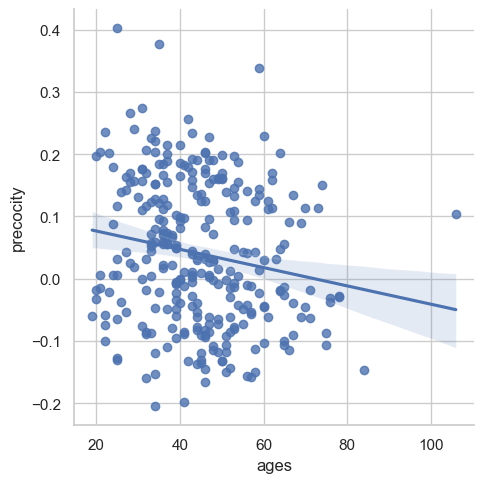

In [27]:
# Select 300 rows from reg_df.

reg_df = reg_df.sample(n = 300, replace = False, random_state=40)

# Plot the relationship between precocity and age

sns.lmplot(x = 'ages', y = 'precocity', data = reg_df)

That centenarian is probably an error in the data, but the pattern will survive removing it.

### How good are embeddings at predicting age?

In [35]:
def run_embedding_model(path_to_model, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    date = []
    ages = []

    for decade in range(1910, 1979, 3):
        
        data = pd.read_csv(path_to_model + str(decade) + 's_docs.tsv', sep = '\t')
        data['docid'] = data['docid'].astype(str)
        data.set_index('docid', inplace=True)
        
        data = data.join(agemeta['author_age'], how='inner')
        
        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        try:
            r, p = pearsonr(selected.author_age, selected.precocity)
            print(decade, round(r, 5))
        except:
            print('No correlation for ', decade)
            pass

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        date.extend(selected.date.values.tolist())
        ages.extend(selected.author_age.values.tolist())

    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'date': date, 'ages': ages})
    controlled_model(reg_df)
    return reg_df

reg_df = run_embedding_model('../tunedembeddings/ficresults/precocity_fiction_', chunksused = 0.25, fractioncompared = 1.0)

1910 -0.27052
1913 -0.17338
1916 -0.27603
1919 -0.18093
1922 -0.20257
1925 -0.14476
1928 -0.25605
1931 -0.42284
1934 -0.27959
1937 -0.37193
1940 -0.2482
1943 -0.31922
1946 -0.38178
1949 -0.38537
1952 -0.38899
1955 -0.58414
1958 -0.40451
1961 -0.47257
1964 -0.14588
1967 -0.34949
1970 -0.26714
1973 -0.22909
1976 -0.16878
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     166.1
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:56:33   Log-Likelihood:            -1.0366e+05
No. Observations:               26292   AIC:                         2.073e+05
Df Residuals:                   26274   BIC:                         2.075e+05
Df Model:                          17          

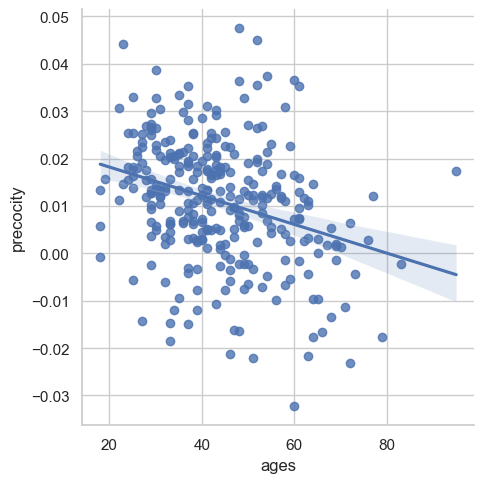

In [36]:
# Select 300 rows from reg_df.

reg_df = reg_df.sample(n = 300, replace = False, random_state=40)

# Plot the relationship between precocity and age

sns.lmplot(x = 'ages', y = 'precocity', data = reg_df)

This relationship is stronger; embeddings explain almost 9% of the variance in author age, where precocity calculated on a topic model could only explain 5%. Maybe embeddings are better suited to capture subtleties of phrasing that correlate with generational cohorts.

## Are books discussed by critics generally ahead of their time?

The list of books that are referenced in critical articles is pushed up to repo as CommonlyReferenced.tsv. We have a count of references for each book, but right now I wouldn't be comfortable drawing inferences from the relative positions of books in that list. Books with short titles and common author names may be slightly advantaged, and I want to correct for that — and also first-mover advantage! early books have more chances to be mentioned — before comparing differences of degree.

Here we'll more crudely compare two sets, that were or were not mentioned by critics: `discussed` and `discussed_contrast.` The latter is distributed across time in the same way as discussed, so a model correcting for time is not necessary. We can just do a t-test.

#### How good is a topic model at capturing the kind of innovation that interests critics?

# 

In [6]:
def print_effect_size(t, p, df):
    ''' Calculates Cohen's d and r2
    for t-test statistics.'''

    d = 2*t / math.sqrt(df)
    r2 = t**2 / (t**2 + df)

    print(f'Cohens d is {d} and r2 is {r2}.')


In [7]:
dis_kld_precoc = []
notdis_kld_precoc = []

for decade in range(10, 80, 5):
	
	data = pd.read_csv('../topicmodel/ficresults/precocity_tuned_19' + str(decade) + 's_docs.tsv', sep = '\t')
	data['docid'] = data['docid'].astype(str)
	data.set_index('docid', inplace=True)

	selected = pd.DataFrame(data.loc[(data.time_radius == 20) & (data.filtered == 'trainauth') & (data.chunks_used == .25) & (data.fraction_compared == 1.0), :])
	
	dis_kld_precoc.extend(selected.loc[selected.index.isin(discussed), 'precocity'])
	notdis_kld_precoc.extend(selected.loc[selected.index.isin(discussed_contrast), 'precocity'])

t, p = ttest_ind(dis_kld_precoc, notdis_kld_precoc)
df = len(dis_kld_precoc) + len(notdis_kld_precoc) - 2
print(t, p, df)
print_effect_size(t, p, df)

9.321138080440837 4.446692883827821e-20 1371
Cohens d is 0.5034776654770944 and r2 is 0.05959571409807771.


That's a moderately strong effect. Here's what it looks like.

<Axes: >

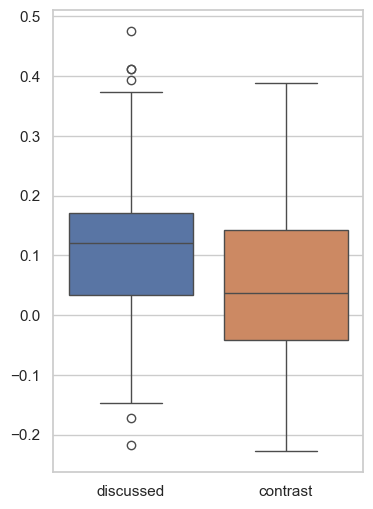

In [8]:
# Use seaborn to visualize the difference in precocity between discussed and contrast documents

plt.figure(figsize=(4, 6))
sns.boxplot(x = ['discussed'] * len(dis_kld_precoc) + ['contrast'] * len(notdis_kld_precoc), y = dis_kld_precoc + notdis_kld_precoc, \
            hue = ['discussed'] * len(dis_kld_precoc) + ['contrast'] * len(notdis_kld_precoc))

### We used the top quarter of chunks above. Is that helping predict 'citations' of fiction as it did with academic articles?

Yes. If we use all of them we get a smaller effect.

In [9]:
dis_kld_precoc = []
notdis_kld_precoc = []

for decade in range(10, 80, 5):
	
	data = pd.read_csv('../topicmodel/ficresults/precocity_tuned_19' + str(decade) + 's_docs.tsv', sep = '\t')
	data['docid'] = data['docid'].astype(str)
	data.set_index('docid', inplace=True)

	selected = pd.DataFrame(data.loc[(data.time_radius == 20) & (data.filtered == 'trainauth') & (data.chunks_used == 1.0) & (data.fraction_compared == 1.0), :])
	
	dis_kld_precoc.extend(selected.loc[selected.index.isin(discussed), 'precocity'])
	notdis_kld_precoc.extend(selected.loc[selected.index.isin(discussed_contrast), 'precocity'])

t, p = ttest_ind(dis_kld_precoc, notdis_kld_precoc)
df = len(dis_kld_precoc) + len(notdis_kld_precoc) - 2
print(t, p, df)
print_effect_size(t, p, df)

6.585832349663469 6.428008787884464e-11 1371
Cohens d is 0.35573118518541147 and r2 is 0.03066601383135963.


#### How good are embeddings at predicting 'citations' of fiction?

In [61]:
dis_embed_precoc = []
notdis_embed_precoc = []

for decade in range(10, 79, 3):
	
	try:
		data = pd.read_csv('../tunedembeddings/ficresults/precocity_fiction_19' + str(decade) + 's_docs.tsv', sep = '\t')
	except:
		print(decade)
		continue
	data['docid'] = data['docid'].astype(str)
	data.set_index('docid', inplace=True)

	selected = pd.DataFrame(data.loc[(data.time_radius == 20) & (data.filtered == 'trainauth') & (data.chunks_used == .25) & (data.fraction_compared == 1.0), :])

	dis_embed_precoc.extend(selected.loc[selected.index.isin(discussed), 'precocity'])
	notdis_embed_precoc.extend(selected.loc[selected.index.isin(discussed_contrast), 'precocity'])

t, p = ttest_ind(dis_embed_precoc, notdis_embed_precoc)
df = len(dis_embed_precoc) + len(notdis_embed_precoc) - 2
print(t, p, df)
print_effect_size(t, p, df)

2.600385514781956 0.009460123112619746 927
Cohens d is 0.17081573214859921 and r2 is 0.007241679132951634.


That's still significant, but a much weaker effect than in the topic model. However, you'll also notice that we're missing about 350 books! I don't know where they went yet, and I definitely need to track that down.

However, assuming this result doesn't get much stronger when I find the missing books, we potentially confront a conundrum. Embeddings seem to be better at modeling author age, at least in fiction. But the topic model seems to better capture the kind of innovation that distinguishes books of critical interest from those ignored by critics.

We probably need to see if the same thing holds true in literary studies. We could manually infer birth years for a sample of 50-100 prolific critics, which might give us 3x that number of articles?

Between filling in that detail for literary studies, and firming up our confidence about the missing books, we might be able to say whether the difference we're seeing is that embeddings are more suited *to fiction*, or more suited to capturing the *kinds of syntactic details that distinguish generational cohorts*.

Either way, I think it's likely that we also conclude that topic models, frankly, don't suck as models of innovation in fiction. The differences between topic models and embeddings so far are subtle shades. It's not like we see a major pattern in one that's totally missing in the other.